In [1]:
import numpy as np
import splat
import wisps
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import wisps.simulations as wispsim

In [3]:
import wisps.simulations.compute_distances as comp

In [4]:
from astropy.coordinates import SkyCoord

In [5]:
J1_NIPS=24 #limiting mag in NISP
J2_NIPS=27 #best case scenario

In [6]:
import splat
import splat.empirical as spe

In [7]:
spe.typeToMag(np.ones(12), '2MASS J')

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]))

In [8]:
def get_abs_mag(spt):
    #magnitude from spt and relation
    spts=np.random.normal(spt, 0.4, 10000)
    mags=spe.typeToMag(spts, '2MASS J')[0]
    return [np.mean(mags), np.nanstd(mags)]

In [9]:
spgrid=np.arange(17, 38)

In [10]:
abs_mags=np.array([get_abs_mag(s ) for s in spgrid])

In [11]:
dmaxs1=wispsim.get_distance(abs_mags[:,0], np.ones_like(abs_mags[:,0])*J1_NIPS)
dmaxs2=wispsim.get_distance(abs_mags[:,0], np.ones_like(abs_mags[:,0])*J2_NIPS)

In [12]:
import astropy.units as u

In [13]:
EDFS=SkyCoord(l=24.6*u.deg, b=-82.0*u.deg , frame='galactic').icrs
EDF_CH=SkyCoord("3:32:28.0 -27:48:30" , obstime="J2000", unit=u.deg)

In [14]:
#compute volume correction terms 
EDFS_vcs1=np.array([ comp.custom_volume_correction(EDFS, 1., dm, 350.) for dm in dmaxs1])
EDF_CH_vcs1=np.array([ comp.custom_volume_correction(EDF_CH, 1., dm, 350.) for dm in dmaxs1])

EDFS_vcs2=np.array([ comp.custom_volume_correction(EDFS, 1., dm, 350.) for dm in dmaxs2])
EDF_CH_vcs2=np.array([ comp.custom_volume_correction(EDF_CH, 1., dm, 350.) for dm in dmaxs2])

In [15]:
EDFS_CH_vols1=dmaxs1**3*EDF_CH_vcs1*(20*(u.deg**2)).to(u.radian**2)
EDF_vols1=dmaxs1**3*EDFS_vcs1*(10*(u.deg**2)).to(u.radian**2)

EDFS_CH_vols2=dmaxs2**3*EDF_CH_vcs2*(20*(u.deg**2)).to(u.radian**2)
EDF_vols2=dmaxs2**3*EDFS_vcs2*(10*(u.deg**2)).to(u.radian**2)

In [16]:
LF=wisps.LUMINOSITY_FUCTION

In [17]:
from scipy.interpolate import interp1d

In [18]:
lf=interp1d(LF.spts.values, LF.lsfim.values)

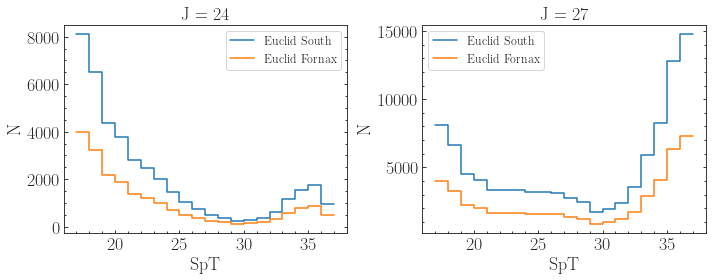

In [19]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 4), sharey=False, sharex=True)
ax.step(spgrid, lf(spgrid)*EDFS_CH_vols1, label='Euclid South')
ax.step(spgrid, lf(spgrid)*EDF_vols1, label='Euclid Fornax')

ax1.step(spgrid, lf(spgrid)*EDFS_CH_vols2, label='Euclid South')
ax1.step(spgrid, lf(spgrid)*EDF_vols2, label='Euclid Fornax')

ax.set_title('J = {}'.format(J1_NIPS), fontsize=18)
ax1.set_title('J = {}'.format(J2_NIPS), fontsize=18)
for a in [ax, ax1]:
    a.minorticks_on()
    a.set_xlabel('SpT', fontsize=18)
    a.legend()
    a.set_ylabel(r'N', fontsize=18)


plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/euclid_predictions.pdf')

In [20]:
total=(lf(spgrid)*EDFS_CH_vols1+lf(spgrid)*EDF_vols1).value

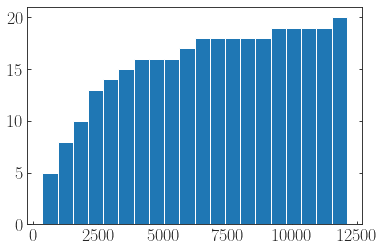

In [21]:
_, ht, _=plt.hist(total, cumulative=True, bins=len(spgrid)-1)